In [1]:

# !pip install ipykernel

import os 

os.chdir('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main')
# from dataloaders.datasets.nyud_geonet import NYUD_GeoNet

from dataloaders.datasets.iiw_dataset import IIWDataset
import matplotlib.pyplot as plt
import numpy as np 
import cv2
import scipy.io as scio
from eval_tools.iiw_evaluator import IIWEvaluator

from os.path import join, split, exists, isdir, isfile
from utils import * 

plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率


In [2]:


def normalize(data):
    return (data-data.min())/(data.max()-data.min())




In [3]:
data_root = '/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/data/IIW/iiw-dataset'
trainset = IIWDataset(data_dir=data_root,split='test')

# print(len(sample))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) 123 123 torch.Size([3, 512, 512]) 141
shape :(512, 512, 3)
shape :(512, 512, 3)


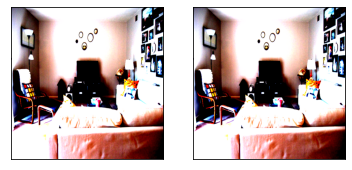

shape :(512, 512, 3)
shape :(512, 512, 3)


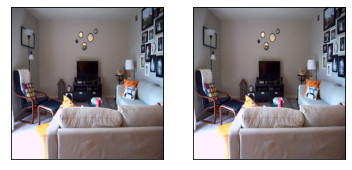

In [4]:
# # * [image, the point  corresponding to the label, the label corresponding to the points, image name, transformation guidance image ]

# sample = trainset.getitem(0)
# image = sample[0]
# labels_points = sample[1] 
# labels = sample[2]
# guidance= sample[4]
# name = sample[3]
# print(image.shape,len(labels_points),len(labels),guidance.shape,name)

# show_imgs([image.permute(1,2,0).numpy(),guidance.permute(1,2,0).numpy()],[0,0])
# show_imgs([normalize(image.permute(1,2,0).numpy()),normalize(guidance.permute(1,2,0).numpy())],[0,0])

In [5]:
# image,name = sample
# print(image.shape,name)

## Analyse qualitative results

In [6]:
from tqdm import tqdm 
path = '/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/iiw_1/reflectance'

mat_dir = join(path,'met')
tgt_dir = join(path, 'images')
make_dir(tgt_dir)


file_list = os.listdir(mat_dir)
for idx,f in tqdm(enumerate(file_list),total=len(file_list)):
    save_path = join(tgt_dir,f.split('.')[0]+".png")
    if exists(save_path):
        continue

    if isfile(join(mat_dir,f)):
      

        data = load_mat(join(mat_dir,f))
        
        # plt.subplot(((idx+1)//5+1),(idx+1)%5,idx+1)
        # plt.subplot(2,5,idx+1)
        plt.figure()
        im = plt.imshow(data['result'],cmap='jet')

        # if (idx+1) %5==0:

        # plt.colorbar(im,fraction=0.03, pad=0.025)
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.savefig(save_path)


        


100%|██████████| 1046/1046 [00:00<00:00, 137294.38it/s]


## comtrast to Ofnet 

In [9]:
import torch
import cv2

def draw_point(img,point,point_color=(255,0,0),point_size = 1,thickness = 4):
    # thickness = 4 # 可以为 0 、4、8
    cv2.circle(img,point, point_size, point_color, thickness)

def gen_color():
    return (np.random.random((1,3))*255).astype(np.int32)[0].tolist() # BGR


def draw_point_pair(img,p1,p2):
    img = check_img(img)
    point_color = gen_color()
    draw_point(img,p1,point_color)
    draw_point(img,p2,point_color)
    draw_arraw(img,p1,p2,color=point_color,thickness=2,tipLength=0.09)
    
    return img

def draw_arraw(src,p1,p2,color=(0,0,255),thickness=2,line_type=0,shift=0,tipLength=0.1):
    """
    # int thickness #线宽
    # int line_type #线的类型
    # int shift #箭头位置平移系数
    # double tipLength  #箭头大小缩放系数
    """
    
    
    
    # Mask = 255*np.ones((100,100,3), dtype=np.int)
    # Mask = np.array(Mask, dtype='uint8')
    cv2.arrowedLine(src,p1, p2, color,thickness,line_type,shift,tipLength)




    
def draw_label(img,label_points,labels):
    if img.max()<=1:
        img = np.array(img*255,dtype=np.uint8)

    img = check_img(img)
    image_shape=torch.from_numpy(np.array(img.shape[:-1]))

    for idx,(points,label) in enumerate(zip(label_points,labels)):#* value range is between 0 and 1 

        # print(labels[idx])
        if label[0]!='E':
            p1= (points[0]*image_shape).int().numpy()
            p2= (points[1]*image_shape).int().numpy()
            img=draw_point_pair(img,p1,p2)
            # print(f"draw points")
            
    # show_imgs([img],[0])
    return img

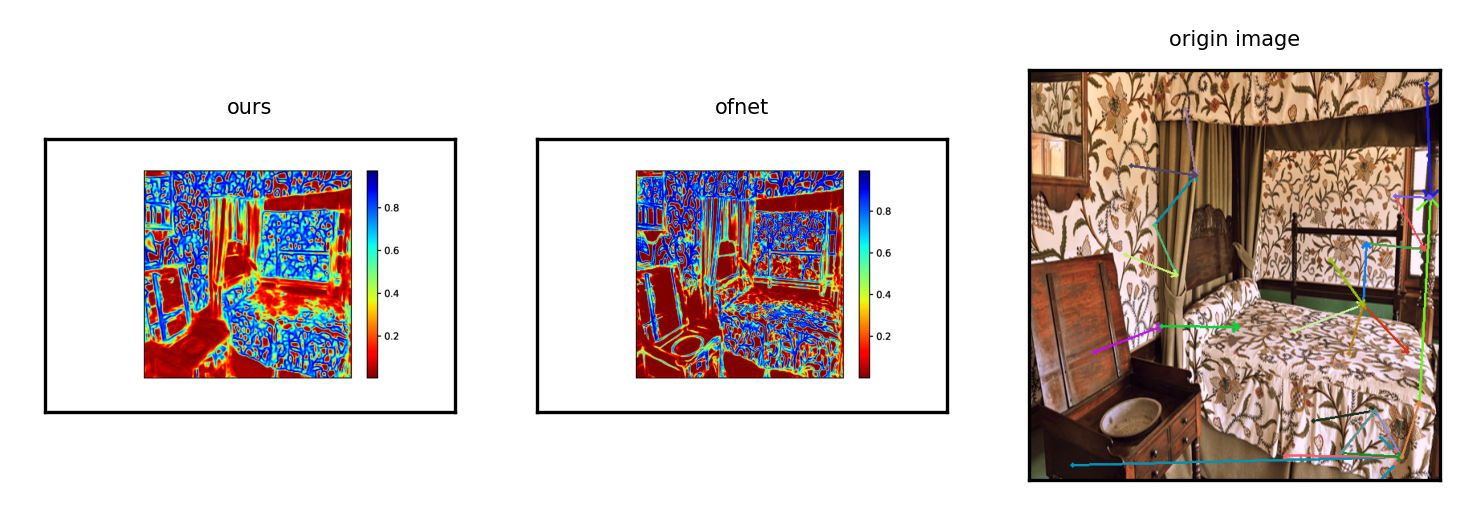

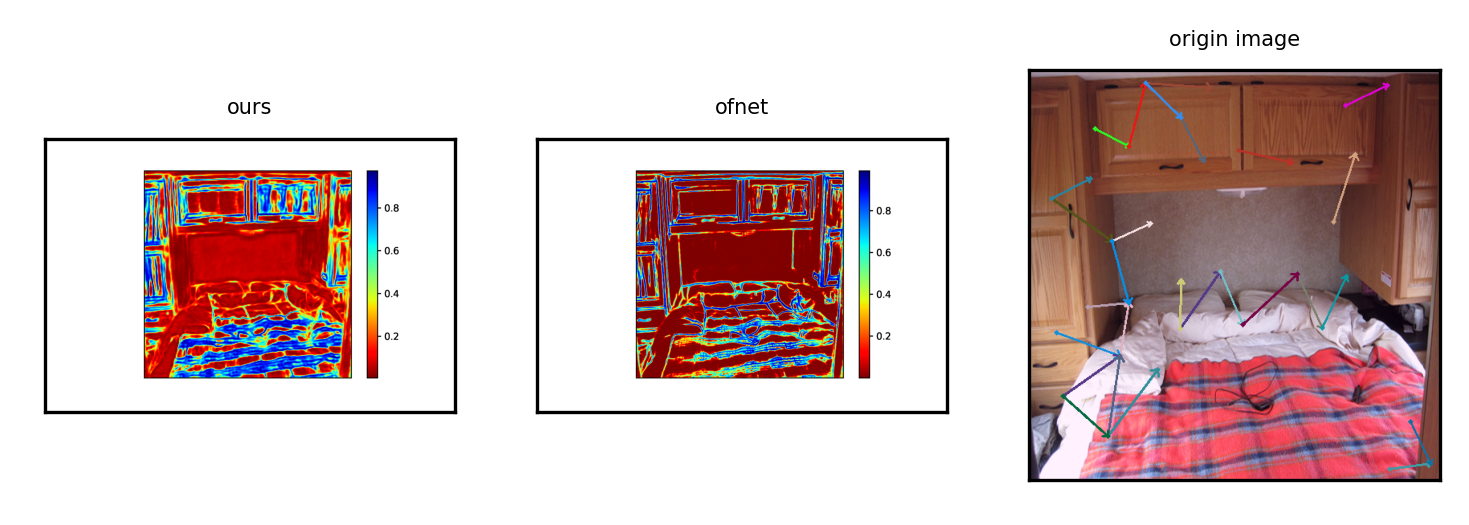

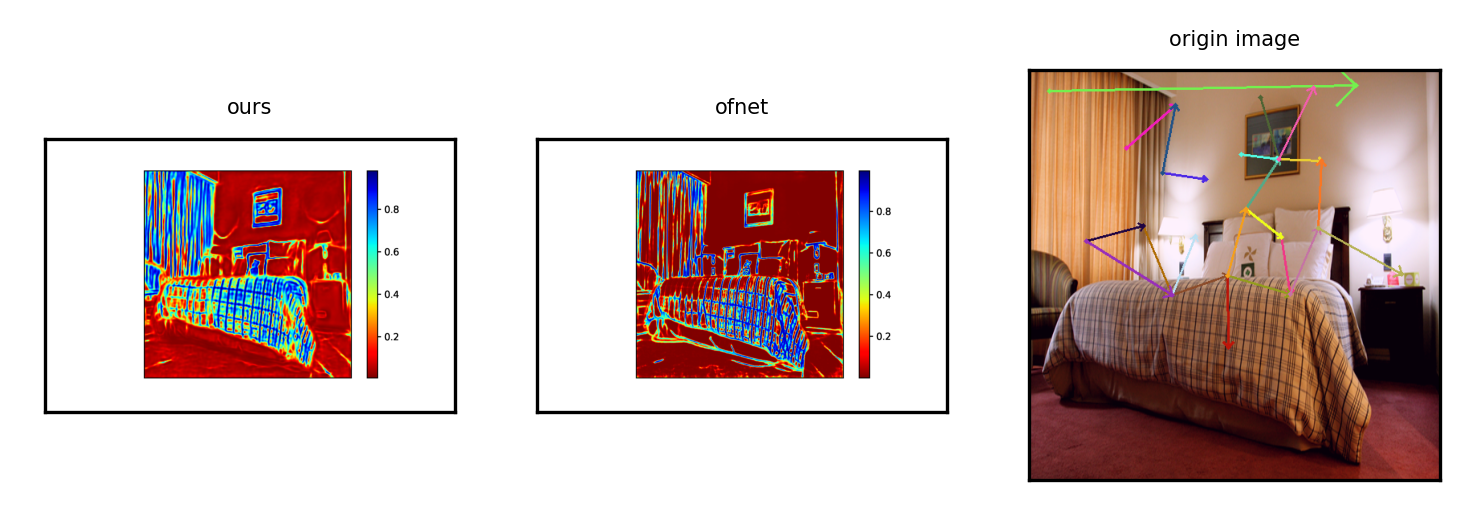

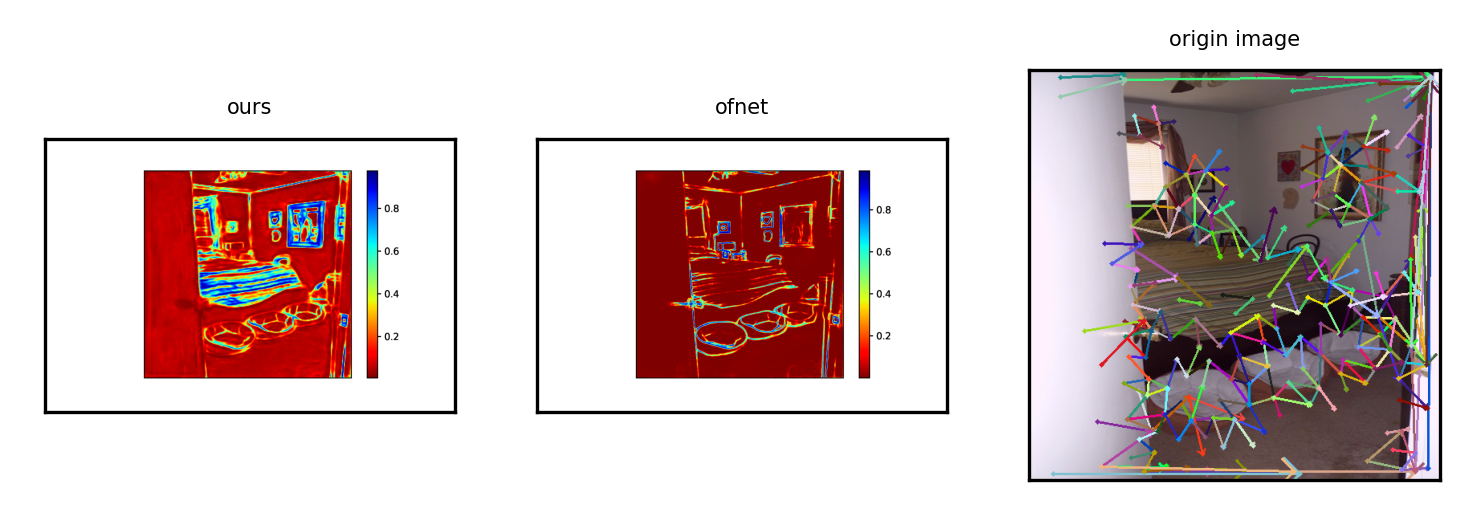

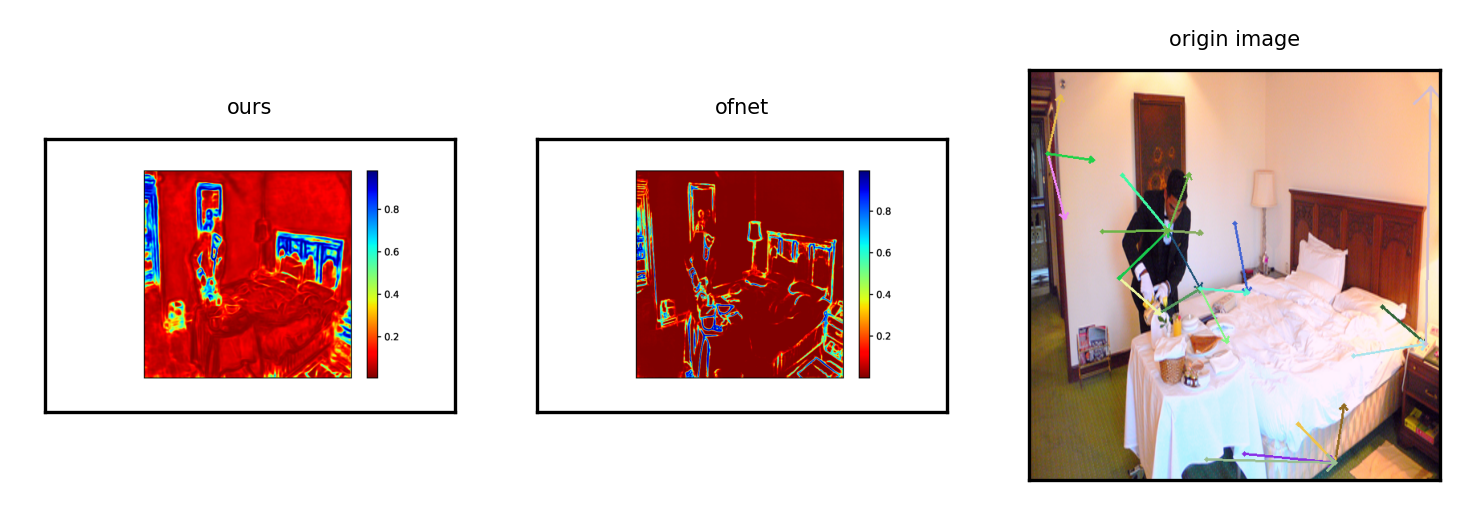

libpng warning: iCCP: known incorrect sRGB profile


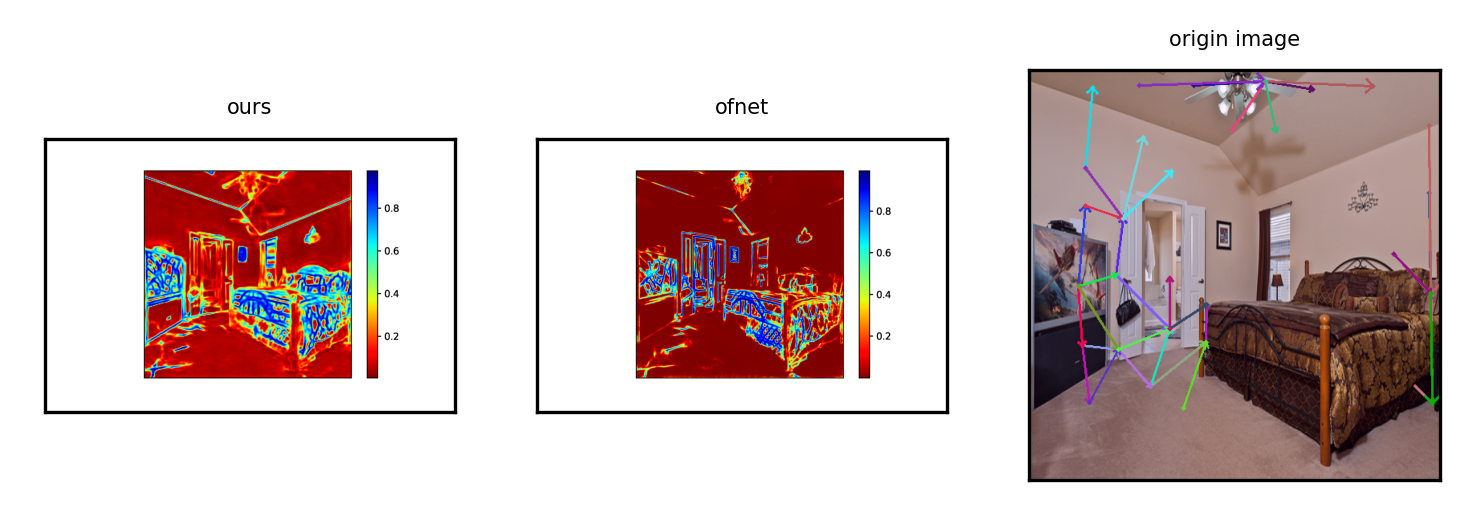

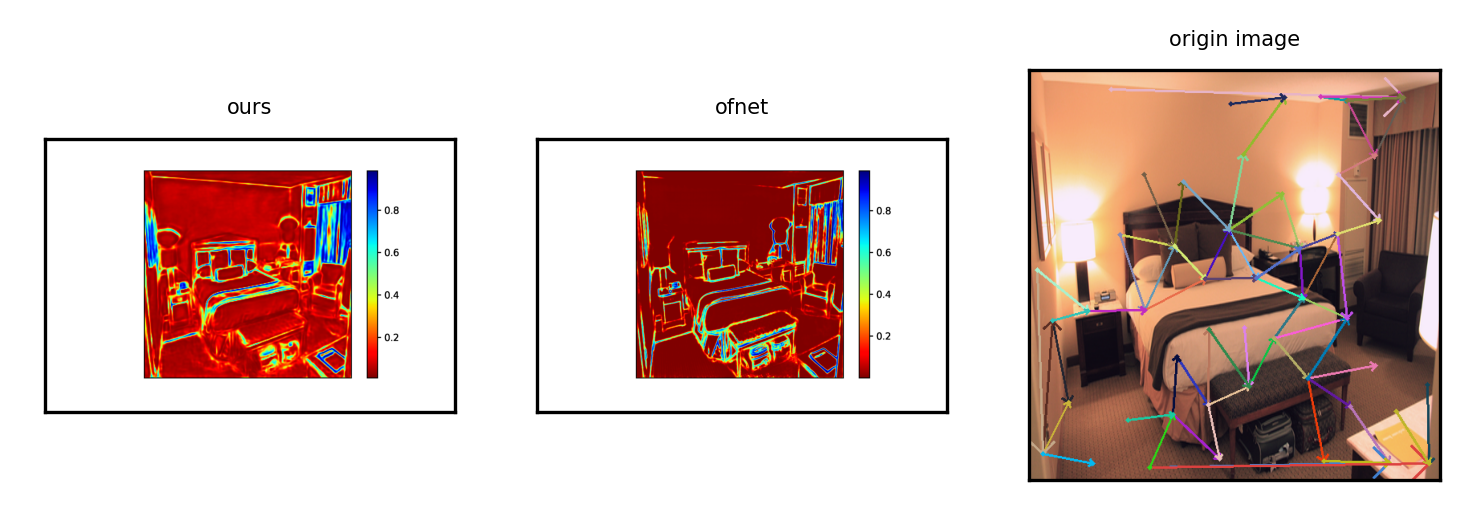

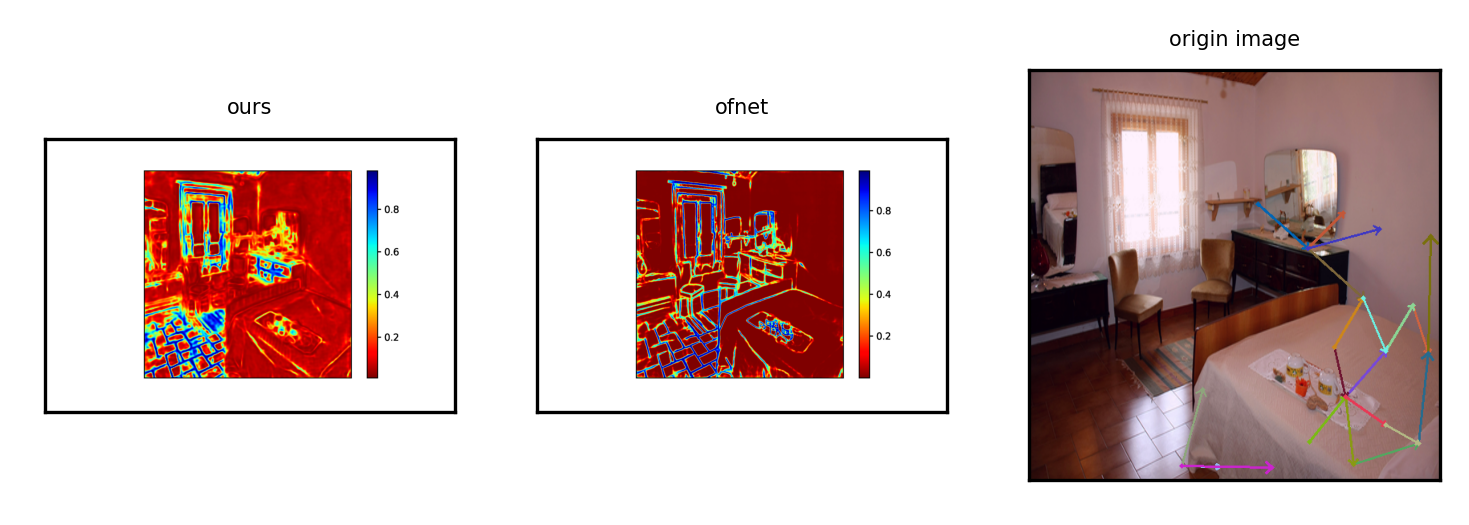

libpng warning: iCCP: known incorrect sRGB profile


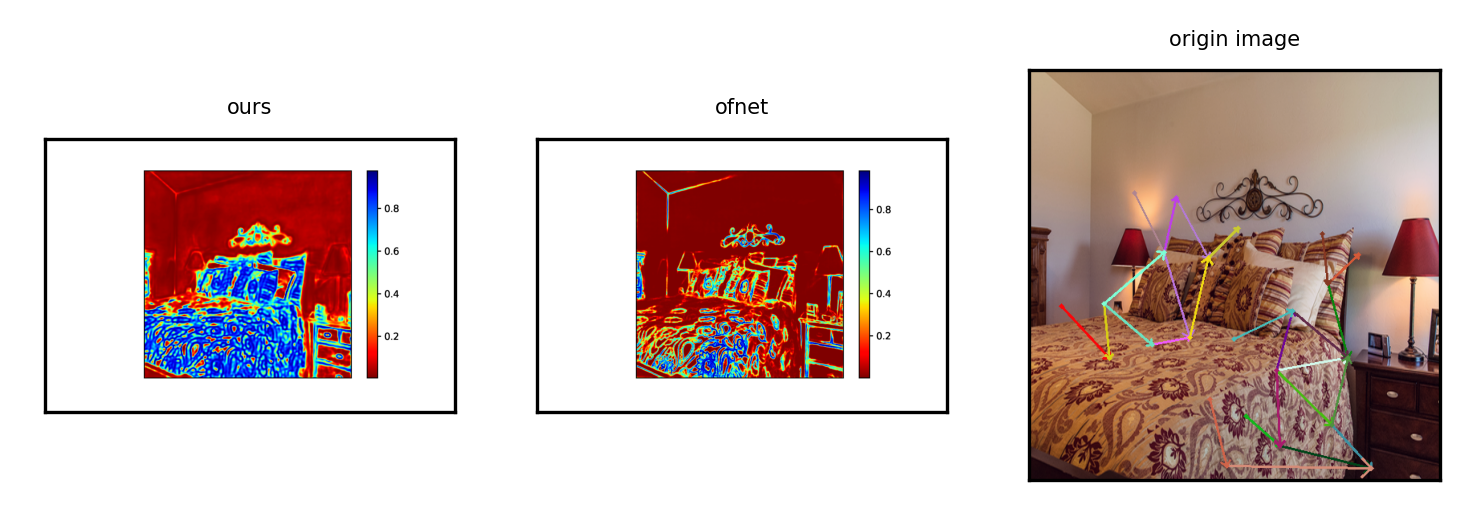

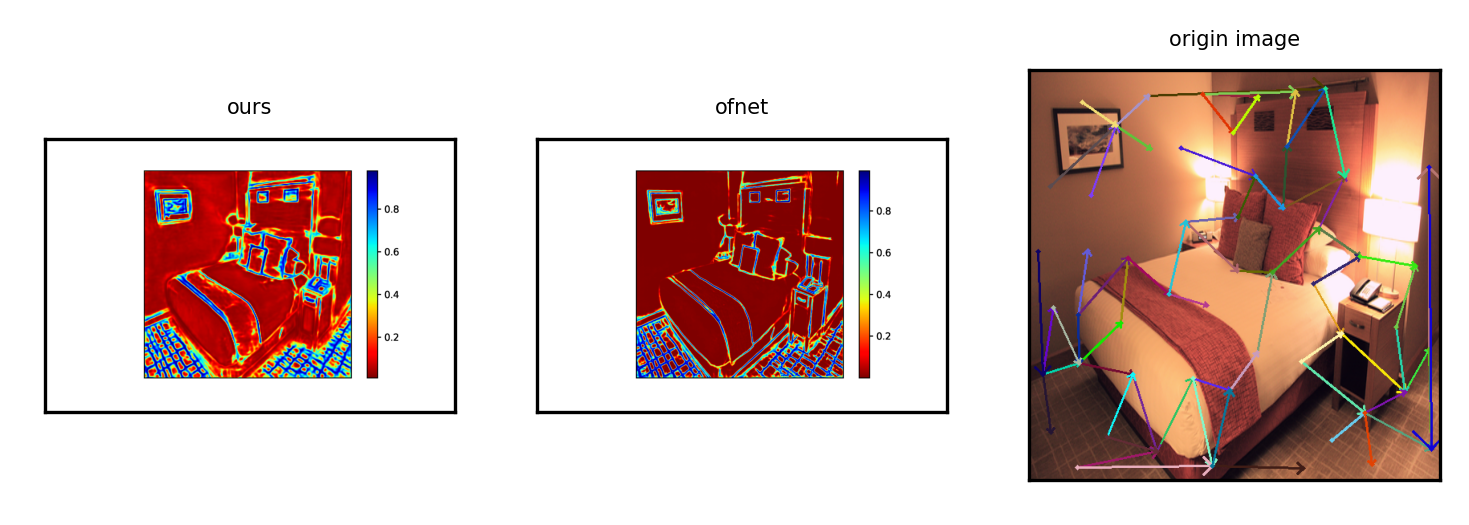

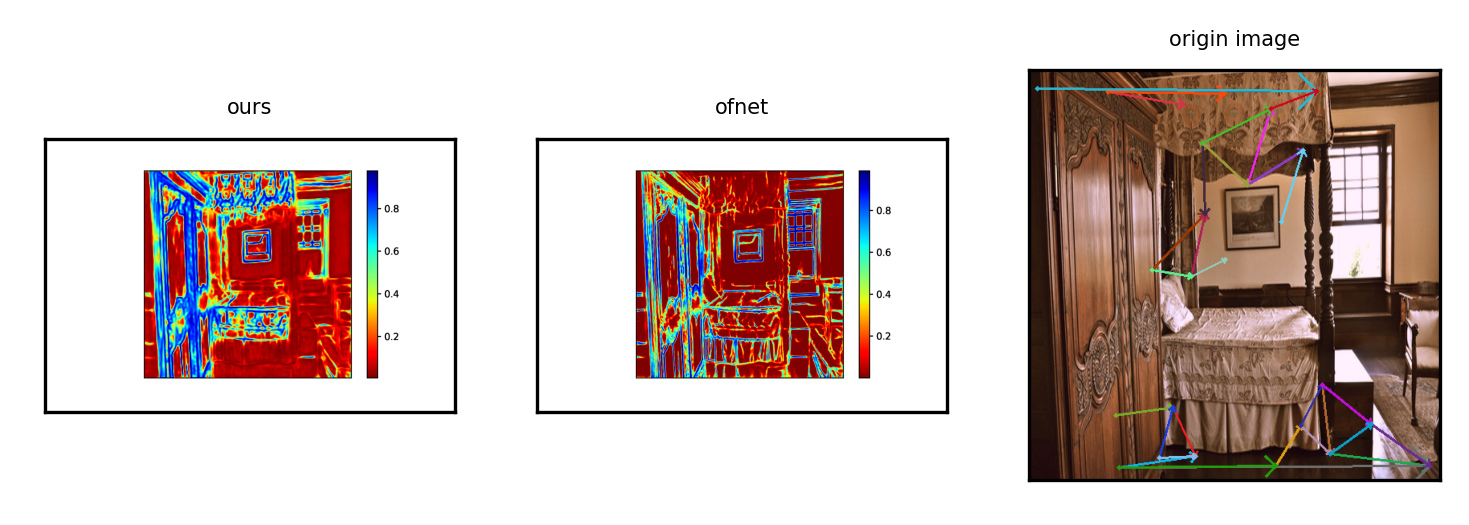

In [10]:
import  torchvision.transforms  as transforms



def get_dir_files(path):
    return sorted(os.listdir(path))


data_path = '/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/data/IIW/iiw-dataset/data'
mine = join('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/iiw_1/reflectance', 'images')
ofnet = "/home/DISCOVER_summer2022/xusc/exp/RINDNet-main/run_IIW/ofnet/reflectance/images"


files = get_dir_files(mine)

dataset = IIWDataset(data_dir='/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/data/IIW/iiw-dataset',split='test')
to_img = transforms.ToPILImage()

for idx,f in enumerate(files):
    if isfile(join(mine,f)):

        my_res = imread(join(mine,f))

        ofnet_res = imread(join(ofnet,f))

        origin_img = imread(join(data_path,f))        

        image,point,label = dataset.getitem_by_name(f.split('.')[0])
        
        image = np.array(to_img(normalize(image)))

        label_img = draw_label(image,point,label)
        
        show_imgs([my_res,ofnet_res,label_img],[0,0,0,0,],['ours','ofnet','origin image'])
        
        # show_imgs([my_res,ofnet_res],[0,0,0,0,])
        
    
    if idx ==10:
        break



